# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

Импортируем библиотеки.

In [60]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

Прочитаем данные с файла и сохраним в data. Также обозначим столбец индекса.

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

Посмотрим общую информацию в data.

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Согласно документации к данным, в таблице `autos` имеются следующие столбцы:
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

### Проверка данных

Проверим наличие явных дубликатов.

In [4]:
data.duplicated().sum()

4

Найдено 4 явных дубликата, поэтому удалим их.

In [5]:
data = data.drop_duplicates()

В таблице `autos` есть строковые столбцы VehicleType, Gearbox, Model, FuelType, Brand, Repaired. Проверим их на наличие неявных дубликатов.

In [6]:
print(data['VehicleType'].sort_values().unique())
print(data['Gearbox'].sort_values().unique())
print(data['Model'].sort_values().unique())
print(data['FuelType'].sort_values().unique())
print(data['Brand'].sort_values().unique())
print(data['Repaired'].sort_values().unique())

['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
['auto' 'manual' nan]
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_k

Неявных дубликатов в таблице не обнаружено.

В таблице есть несколько столбцов со временем, которые имеют тип object. Преобразуем их в тип datetime.

In [7]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format = '%Y-%m-%d %H:%M:%S')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


В таблице уже видны пропущенные значения.

In [8]:
print("Количество пропусков в data:"'\n', data.isna().sum())

Количество пропусков в data:
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Посчитаем процент пропусков в каждом столбце.

In [9]:
display(pd.DataFrame(round((data.isna().mean()*100),2), columns=['NaNs, %']).sort_values(by='NaNs, %', ascending=False))

,"NaNs, %"
Repaired,20.08
VehicleType,10.58
FuelType,9.28
Gearbox,5.60
Model,5.56
DateCrawled,0.00
Price,0.00
RegistrationYear,0.00
Power,0.00
Kilometer,0.00


Большой процент пропусков в столбце со значением была ли машина в ремонте или нет. Это может быть связано с тем человек может не  знать, была ли когда-то отремонтирована его машина (авто куплено б/у и т.п.).

Пока трогать пропуски не будем.

### Подготовка данных

Удалим ненужные для обучения столбцы

In [10]:
data = data.drop(columns=['LastSeen', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode'])
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


Проверим наличие аномальных значений.

Price


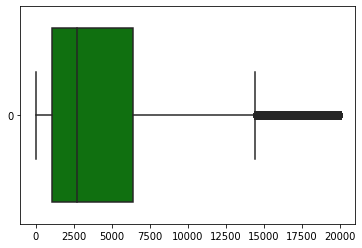

RegistrationYear


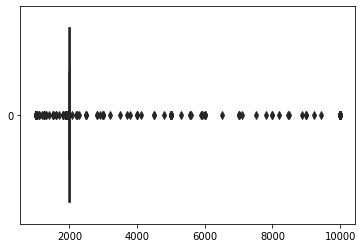

Power


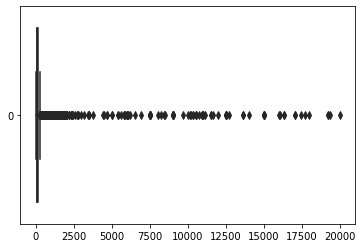

Kilometer


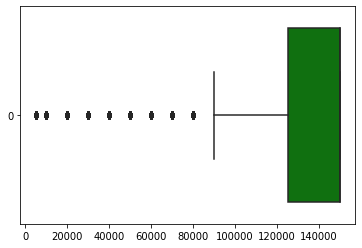

In [11]:
for i in data:
    if data[i].dtypes == 'int64':
        print(i)
        sns.boxplot(data= data[i], orient='h', color='g')
        plt.show()

В столбцах price, registrationyear, power есть аномальные значения. 

#### Обработка Price

Проверим значения ниже 100 евро.

In [12]:
data[data['Price']<100]['Price'].value_counts().sort_index().head()

0    10772
1     1189
2       12
3        8
4        1
Name: Price, dtype: int64

Ниже 100 евро встречатся только значения от 0 до 4 евро. Такая цена очень подозрительна.

Проверим распределение цены.

18800.0

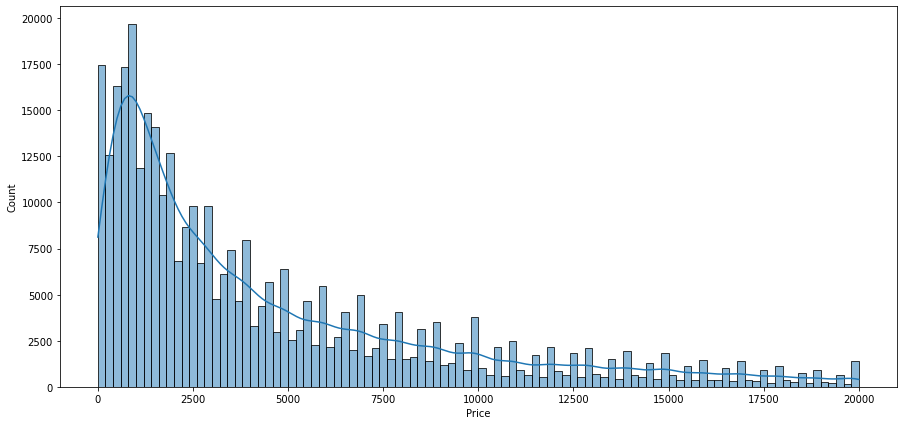

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data['Price'], bins = 100, ax = ax, kde=True)
data['Price'].quantile(0.99)

#### Обработка RegistrationYear

Проверим уникальные значения года регистрации.

In [14]:
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Первый автомобиль появился только в 1885 году, поэтому значения до явно аномальные. Также значения от 2066 года физически не могут существовать, поэтому удалим их из выборки.

In [15]:
data = data.query('1910 <= RegistrationYear <= 2019')

Построим распределение годов.

1992.0

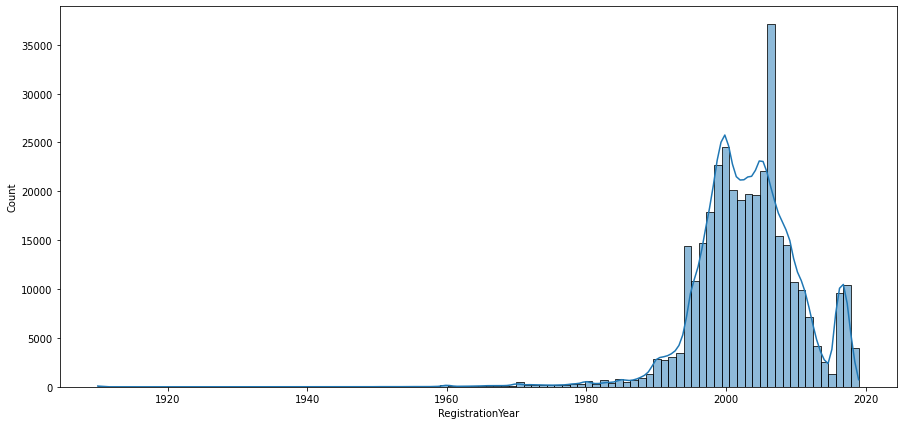

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data['RegistrationYear'], bins = 100, ax = ax, kde=True)
data['RegistrationYear'].quantile(0.05)

95% автомобилей от 1993 года выпуска, однако видим что все-таки повышение колличества авто идет от 1970 года, поэтому удалим из выборки только авто произведенные до 70х. Также практически нет авто произведенных после 2016 года.

In [17]:
data = data.query('1970 <= RegistrationYear <= 2016')

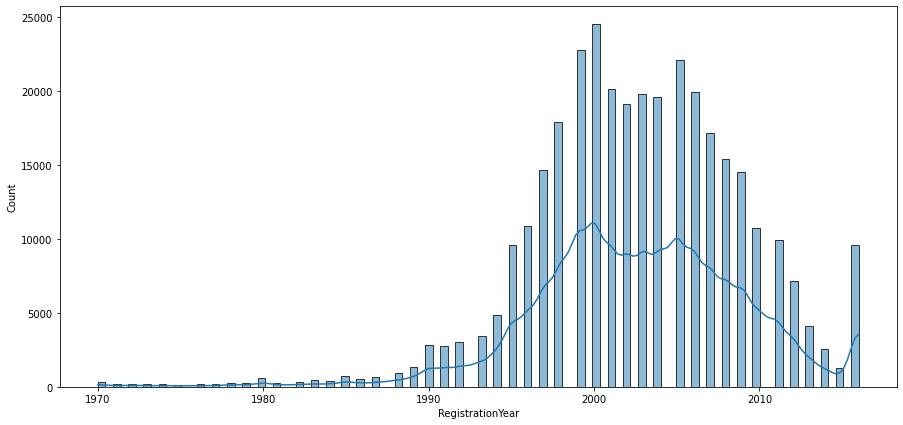

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data['RegistrationYear'], bins = 100, ax = ax, kde=True)
plt.show()

### Обработка Power

Построим распределение мощности.

218.0

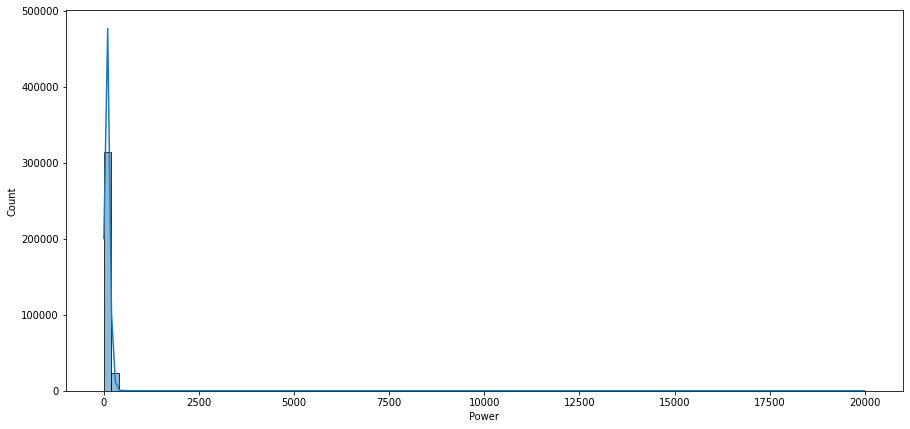

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data['Power'], bins = 100, ax = ax, kde=True)
data['Power'].quantile(0.95)

Очень много нулевых значений. Восстановить их нельзя, поэтому исключим их из выборки.

306.0

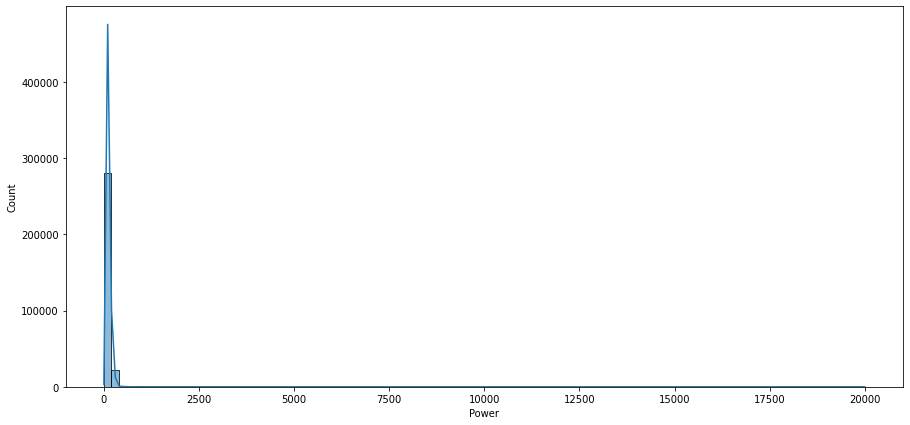

In [20]:
data = data.query('0 < Power')
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data['Power'], bins = 100, ax = ax, kde=True)
data['Power'].quantile(0.99)

99% процентов значений не превышают показатель в 306, значит отсальные значения можно исключить. Оставим в выборке значения не превышающие 350.

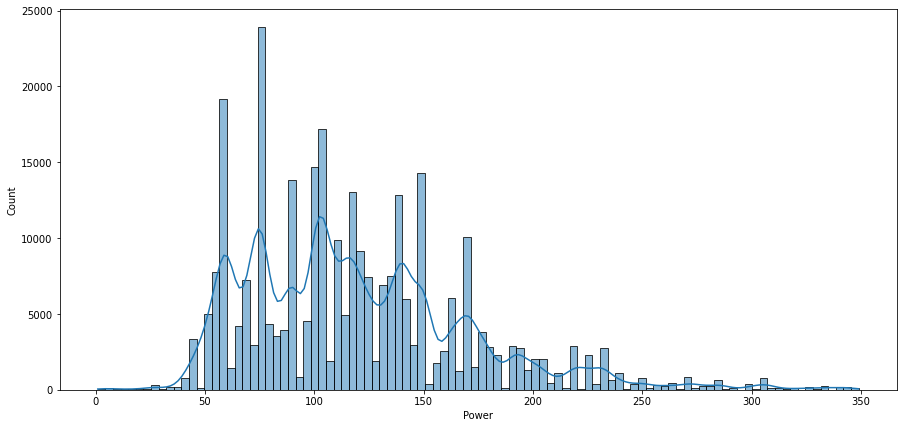

In [21]:
data = data.query('350 > Power')
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data['Power'], bins = 100, ax = ax, kde=True)
plt.show()

### Обработка пропусков

Проверим снова количество пропусков.

In [22]:
display(pd.DataFrame(round((data.isna().mean()*100),2), columns=['NaNs, %']).sort_values(by='NaNs, %', ascending=False))
print("Количество пропусков в data:"'\n', data.isna().sum())

,"NaNs, %"
Repaired,14.94
FuelType,5.52
VehicleType,3.97
Model,3.89
Gearbox,1.89
Price,0.00
RegistrationYear,0.00
Power,0.00
Kilometer,0.00
Brand,0.00


Количество пропусков в data:
 Price                   0
VehicleType         11968
RegistrationYear        0
Gearbox              5698
Power                   0
Model               11731
Kilometer               0
FuelType            16644
Brand                   0
Repaired            45021
dtype: int64


Посмотрим на распределение признаков.

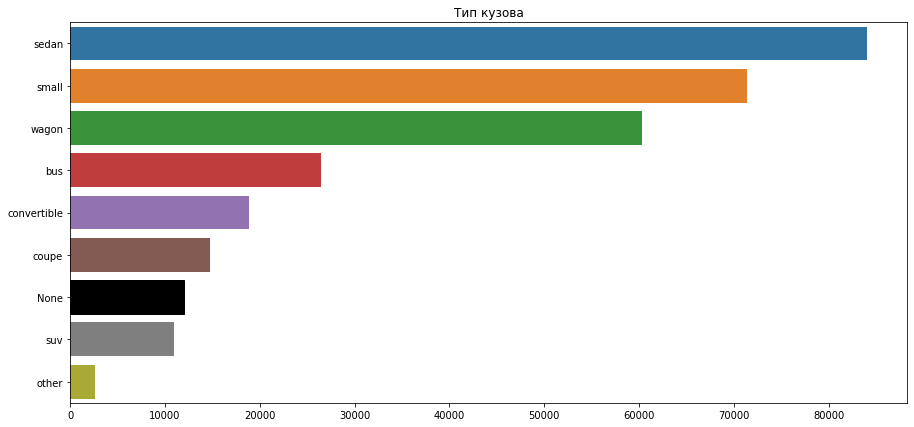

In [23]:
val_counts = data['VehicleType'].fillna('None').value_counts()
plt.figure(figsize=(15, 7))
ax = sns.barplot(x = val_counts.values, y=val_counts.index)
for i in range(len(val_counts.index)):
    if val_counts.index[i] == 'None':
        ax.patches[i].set_color('black')
plt.title('Тип кузова')
plt.show()

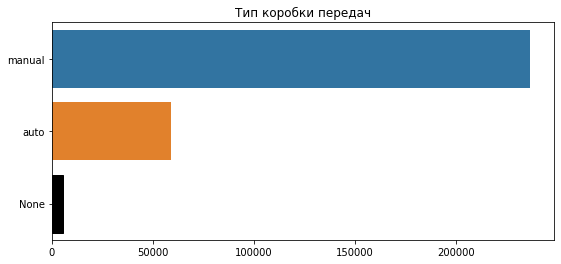

In [24]:
val_counts = data['Gearbox'].fillna('None').value_counts()
plt.figure(figsize=(9, 4))
ax = sns.barplot(x = val_counts.values, y=val_counts.index)
for i in range(len(val_counts.index)):
    if val_counts.index[i] == 'None':
        ax.patches[i].set_color('black')
plt.title('Тип коробки передач')
plt.show()

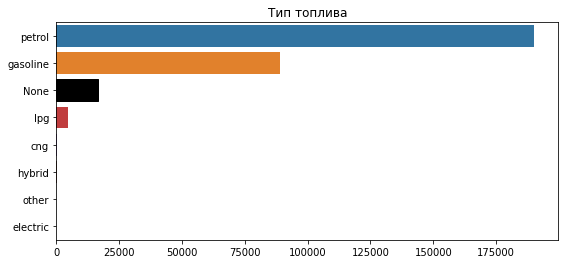

In [25]:
val_counts = data['FuelType'].fillna('None').value_counts()
plt.figure(figsize=(9, 4))
ax = sns.barplot(x = val_counts.values, y=val_counts.index)
for i in range(len(val_counts.index)):
    if val_counts.index[i] == 'None':
        ax.patches[i].set_color('black')
plt.title('Тип топлива')
plt.show()

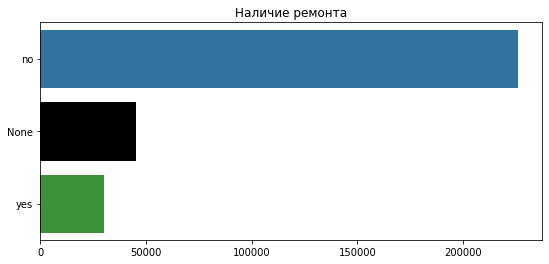

In [26]:
val_counts = data['Repaired'].fillna('None').value_counts()
plt.figure(figsize=(9, 4))
ax = sns.barplot(x = val_counts.values, y=val_counts.index)
for i in range(len(val_counts.index)):
    if val_counts.index[i] == 'None':
        ax.patches[i].set_color('black')
plt.title('Наличие ремонта')
plt.show()

In [27]:
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Пропуски в типе кузова, тип коробки передач, тип топлива заполним по значениям модели и бренда. Пропуски в модели и ремонте заполим значениями `unknown`.

In [28]:
def fill(df, target_col, group_col):
    before = df[target_col].isna().sum()
    df.loc[df[target_col].isna(), target_col] = (df.loc[df[target_col].isna(), group_col].map(
            df.groupby(group_col)[target_col].agg(lambda x: pd.Series.mode(x)[0])))

In [29]:
for i in ['VehicleType', 'Gearbox', 'FuelType']:
    fill(data, i, 'Model')
    fill(data, i, 'Brand')

data['Model'].fillna('unknown', inplace=True)
data['Repaired'].fillna('unknown', inplace=True)

In [30]:
display(pd.DataFrame(round((data.isna().mean()*100),2), columns=['NaNs, %']).sort_values(by='NaNs, %', ascending=False))
print("Количество пропусков в data:"'\n', data.isna().sum())

,"NaNs, %"
Price,0.0
VehicleType,0.0
RegistrationYear,0.0
Gearbox,0.0
Power,0.0
Model,0.0
Kilometer,0.0
FuelType,0.0
Brand,0.0
Repaired,0.0


Количество пропусков в data:
 Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


В итоге все пропуски были заполнены.

Проведем еще раз проверку на явные дубликаты.

In [31]:
data.duplicated().sum()

42476

Появились 42476 новых дубликатов. удалим их.

In [32]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258939 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             258939 non-null  int64 
 1   VehicleType       258939 non-null  object
 2   RegistrationYear  258939 non-null  int64 
 3   Gearbox           258939 non-null  object
 4   Power             258939 non-null  int64 
 5   Model             258939 non-null  object
 6   Kilometer         258939 non-null  int64 
 7   FuelType          258939 non-null  object
 8   Brand             258939 non-null  object
 9   Repaired          258939 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.7+ MB


**Вывод этапа**:
- Проведена проверка на наличие аномальных значений в данных. Были найдены аномалии в столбцах `Price`, `RegistrationYear`и `Power`. В столбце цены оставлены значения от 100 до 15000, в годе регистрации 0т 1970 до 2016 и в мощности от 1 до 300.
- Проведена проверка пропущенных значений. Пропуски найдены в столбцах `Repaired`, `Model` - заполнены значениями *unknown*, `FuelType`, `VehicleType`, `Gearbox`: для заполнения попусков в этих слобцах написана функция определяющая тип по модели и бренду автомобиля.
- Проведена проверка на наличие явных и неянвых дубликатов. Всего было найдено 42480 явных дубликатов (удалены), неяных дубликатов необнаружено.

## Обучение моделей

### Подготовка данных

Для обучения моделей необходимо закодировать и масштабировать признаки, поэтому воспользуемся методами Ordinal и OHE.

Выделим целевые признаки и атрибуты для OHE.
Для начала переведем категориальные значения столбцов в колличественные.

In [34]:
ohe = pd.get_dummies(data, drop_first=True)
ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Выделим обучающую и тестовую выборки.

In [37]:
target_ohe = ohe['Price']
features_ohe = ohe.drop('Price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, 
                                                                                target_ohe, test_size=0.25, random_state=12345) 

print(features_train_ohe.shape)
print(features_test_ohe.shape)

(194204, 307)
(64735, 307)


Масштабируем признаки.

In [40]:
numeric = list(ohe)
numeric.remove('Price')
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
features_train_ohe.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
57032,-0.613720,-0.884356,0.605821,-0.265599,-0.233721,-0.097587,1.543293,-0.562499,-0.200148,-0.505732,...,-0.126232,-0.078785,-0.04846,-0.084536,-0.120686,-0.032108,-0.509278,-0.099821,-0.432327,-0.34564
353699,1.577779,-0.672155,-2.590650,-0.265599,-0.233721,-0.097587,-0.647965,-0.562499,-0.200148,-0.505732,...,-0.126232,-0.078785,-0.04846,-0.084536,-0.120686,-0.032108,1.963565,-0.099821,-0.432327,-0.34564
288648,2.047386,-0.112715,0.605821,-0.265599,-0.233721,-0.097587,1.543293,-0.562499,-0.200148,-0.505732,...,-0.126232,-0.078785,-0.04846,-0.084536,-0.120686,-0.032108,-0.509278,-0.099821,-0.432327,-0.34564
124170,0.168958,-0.093424,-0.060110,-0.265599,-0.233721,-0.097587,-0.647965,1.777781,-0.200148,-0.505732,...,-0.126232,-0.078785,-0.04846,-0.084536,-0.120686,-0.032108,-0.509278,-0.099821,2.313065,-0.34564
276162,-0.613720,-0.363498,-0.060110,-0.265599,-0.233721,-0.097587,1.543293,-0.562499,-0.200148,-0.505732,...,-0.126232,-0.078785,-0.04846,-0.084536,-0.120686,-0.032108,-0.509278,-0.099821,-0.432327,-0.34564


Признаки для OHE готовы, теперь подготовим признаки для Ordinal.

In [54]:
oe = data.copy()
numeric_2 = list(oe)
numeric_2.remove('Price')
numeric_2

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

Выделим выборки.

In [55]:
target_oe = oe['Price']
features_oe = oe.drop('Price', axis=1)
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, 
                                                                        target_oe, test_size=0.25, random_state=12345) 


print(features_train_oe.shape)
print(features_test_oe.shape)

(194204, 9)
(64735, 9)


Используем порядковое кодирование для признаков.

In [57]:
enc = OrdinalEncoder(handle_unknown='ignore')
enc.fit(features_train_oe[numeric_2])
features_train_oe[numeric_2] = enc.transform(features_train_oe[numeric_2])
features_test_oe[numeric_2] = enc.transform(features_test_oe[numeric_2])
features_train_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
57032,4.0,29.0,0.0,74.0,42.0,12.0,6.0,24.0,0.0
353699,0.0,43.0,1.0,85.0,116.0,3.0,6.0,38.0,0.0
288648,4.0,46.0,1.0,114.0,11.0,12.0,6.0,2.0,0.0
124170,5.0,34.0,1.0,115.0,80.0,11.0,6.0,21.0,1.0
276162,4.0,29.0,0.0,101.0,33.0,11.0,6.0,20.0,0.0


Будем проверять работу моделей 3х моделей: LinearRegression, LGBM и CatBoostRegressor с кодированием OHE. 

### Обучение

#### Линейная регрессия

In [61]:
%%time
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
predictions_train_ohe = model.predict(features_train_ohe)

rmse = mean_squared_error(target_train_ohe, predictions_train_ohe)**0.5
print('RMSE LinearRegression:', rmse)

RMSE LinearRegression: 2664.9422788430156
CPU times: user 19 s, sys: 44.5 s, total: 1min 3s
Wall time: 1min 3s


In [81]:
%%time
model = LinearRegression()
model.fit(features_train_oe, target_train_oe)
predictions_train_oe = model.predict(features_train_oe)

rmse_2 = mean_squared_error(target_train_oe, predictions_train_oe)**0.5
print('RMSE LinearRegression:', rmse_2)

RMSE LinearRegression: 3035.8712587928576
CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 216 ms


Как видно, порядковое кодирование обучается намного быстрее, но результат у ОНЕ лучше

#### LightGBM

In [65]:
common_lgb_params = {'metric': 'rmse', 'random_state': 12345}

In [79]:
%%time
params = {'max_depth': [10, 20, 30, 40, 50],'learning_rate': [0.05, 0.1, 0.2],'num_leaves': [50, 100, 250]}
grid_lgb_ohe = GridSearchCV(LGBMRegressor(**common_lgb_params), param_grid=params, **{'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 4})
grid_lgb_ohe.fit(features_train_ohe, target_train_ohe)

display(grid_lgb_ohe.best_params_)
display(grid_lgb_ohe.best_score_*-1)

{'max_depth': 12, 'n_estimators': 1000}

1305.71948

CPU times: user 29min 42s, sys: 20 s, total: 29min 2s
Wall time: 30min 11s


In [80]:
%%time
params = {'max_depth': [10, 20, 30, 40, 50],'learning_rate': [0.05, 0.1, 0.2],'num_leaves': [50, 100, 250]}
grid_lgb_oe = GridSearchCV(LGBMRegressor(**common_lgb_params), param_grid=params, **{'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 4})
grid_lgb_oe.fit(features_train_oe, target_train_oe)

display(grid_lgb_oe.best_params_)
display(grid_lgb_oe.best_score_*-1)

{'max_depth': 12, 'n_estimators': 1000}

1307.101454

CPU times: user 32min 47s, sys: 15 s, total: 33min 2s
Wall time: 33min 17s


OHE показывает лучшее значение.

#### CatBoostRegressor

In [72]:
common_cbr_params = {'loss_function': 'RMSE','random_state': 12345, 'verbose': False}

In [76]:
%%time
params = {'iterations': [1000],'learning_rate': [0.03, 0.1],'depth': [6, 8],'l2_leaf_reg': [1, 3]}
grid_ctb_oe = GridSearchCV(CatBoostRegressor(**common_cbr_params), param_grid=params, **{'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 4})
grid_ctb_oe.fit(features_train_oe, target_train_oe)

display(grid_ctb_oe.best_params_)
display(grid_ctb_oe.best_score_*-1)

{'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

1479.124127

CPU times: user 13min 12s, sys: 0 ns, total: 13min 12s
Wall time: 14min 35s


In [77]:
%%time
params = {'iterations': [1000],'learning_rate': [0.03, 0.1],'depth': [6, 8],'l2_leaf_reg': [1, 3]}
grid_ctb_ohe = GridSearchCV(CatBoostRegressor(**common_cbr_params), param_grid=params, **{'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 4})
grid_ctb_ohe.fit(features_train_ohe, target_train_ohe)

display(grid_ctb_ohe.best_params_)
display(grid_ctb_ohe.best_score_*-1)

{'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

1465.642841

CPU times: user 17min 21s, sys: 0 ns, total: 17min 21s
Wall time: 19min 42s


Лучший результат у кодирования с OHE.

**Вывод этапа**:
- Проведена подготовка данных. Для кодирования столбцов были использованы методы Ordinal и Ohe.
- Проведено исследование нескольких моделей, для которых были получены значения метрики RMSE с кодированием Ordinal и OHE. `LinearRegression:` OE -  3035.87, OHE - 2664.94, `LightGBM:` OE - 1307.10, OHE - 1305.72, `CatBoostRegressor:` OE - 1479.12, OHE - 1465.64.

## Анализ моделей

Выведем результаты работы моделей.

In [82]:
print('LinearRegression OE: RMSE -', round(rmse_2,2))
print('LightGBM OE: RMSE -', round(grid_lgb_oe.best_score_*-1,2))
print('CatBoostRegressor OE: RMSE -', round(grid_ctb_oe.best_score_*-1, 2))
print('LinearRegression OHE: RMSE -', round(rmse, 2))
print('LightGBM OHE: RMSE -', round(grid_lgb_ohe.best_score_*-1, 2))
print('CatBoostRegressor OHE: RMSE -', round(grid_ctb_ohe.best_score_*-1, 2))

LinearRegression OE: RMSE - 3035.87
LightGBM OE: RMSE - 1307.1
CatBoostRegressor OE: RMSE - 1479.12
LinearRegression OHE: RMSE - 2664.94
LightGBM OHE: RMSE - 1305.72
CatBoostRegressor OHE: RMSE - 1465.64


Лучшей моделью показал себя LightGBM с кодированием OHE. Хоть он и показывает лучший результат, он однозначно уступает в скорости CatBoostRegressor.

In [84]:
predictions = grid_lgb_ohe.predict(features_test_ohe)
rmse_3 = mean_squared_error(target_test_ohe, predictions)**0.5
print('RMSE:', rmse_3)

RMSE: 1303.216843


Получили результат работы модели.

**Вывод этапа**:
- Проведен анализ результатов работы всех выбранных моделей:
    * LinearRegression OE: RMSE - 3035.87
    * LightGBM OE: RMSE - 1307.1
    * CatBoostRegressor OE: RMSE - 1479.12
    * LinearRegression OHE: RMSE - 2664.94
    * LightGBM OHE: RMSE - 1305.72
    * CatBoostRegressor OHE: RMSE - 1465.64
- Лучшей моделью по предсказаниям является LightGBM с кодированием OHE. На тестовой выборке результат работы - RMSE: 1303.22.

При выборе модели важны: качество предсказания, скорость предсказания, время обучения. Несмотря на небольшее время обучения моделей LinearRegression и CatBoostRegressor качество предсказаний у них сильно ниже. Поэтому лучше отдать предпочтение модели LightGBM.

## Общий вывод

Итак, были предоставлены данные сервис по продаже автомобилей с пробегом «Не бит, не крашен» для разрабатки приложения для привлечения новых клиентов, в котором можно будет узнать рыночную стоимость своего автомобиля. 

На этапе подготовки данных была проведена проверка на наличие аномальных значений в данных. Были найдены аномалии в столбцах `Price`, `RegistrationYear`и `Power`. В столбце цены оставлены значения от 100 до 15000, в годе регистрации 0т 1970 до 2016 и в мощности от 1 до 300. Найдены пропуски в столбцах `Repaired`, `Model` - заполнены значениями *unknown*, `FuelType`, `VehicleType`, `Gearbox`: для заполнения попусков в этих слобцах написана функция определяющая тип по модели и бренду автомобиля. А также обработаны явные и неянвые дубликаты. Всего было найдено 39819 явных дубликатов (удалены), неяных дубликатов необнаружено.


На этапе обучения моделей кодированы столбцы с помощью методов Ordinal и Ohe. Напиcана функция посчета RMSE метрики. А также проведено исследование нескольких моделей, для которых были получены значения метрики RMSE с кодированием Ordinal и OHE. `LinearRegression:` OE -  3035.87, OHE - 2664.94, `LightGBM:` OE - 1307.10, OHE - 1305.72, `CatBoostRegressor:` OE - 1479.12, OHE - 1465.64.

- Анализ моделей показал следующие результаты работы всех выбранных моделей:
    * LinearRegression OE: RMSE - 3035.87
    * LightGBM OE: RMSE - 1307.1
    * CatBoostRegressor OE: RMSE - 1479.12
    * LinearRegression OHE: RMSE - 2664.94
    * LightGBM OHE: RMSE - 1305.72
    * CatBoostRegressor OHE: RMSE - 1465.64
    
При выборе модели важны: качество предсказания, скорость предсказания, время обучения. Несмотря на небольшее время обучения моделей LinearRegression и CatBoostRegressor качество предсказаний у них сильно ниже. Поэтому лучшей моделью является LightGBM, котрый на тестовой выборке показал RMSE: 1303.22.